# HBV hydrological model forced with ERA5 forcing data
In this notebook we will demonstrate how to generate forcing data for the HBV hydrological model from the ERA5 dataset using the eWaterCycle platform. It is assumed that you already have seen [this notebook which explains the basics of the HBV model and generating forcing using eWaterCycle](example_model_run_HBV_camels_catchment_camels_forcing.ipynb). This notebooks purely focuses on the differences when generating forcing from ERA5.

Below a few collapsed cells are identical to those from that notebook.

In [1]:
# General python
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import numpy as np
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import json

# Niceties
from rich import print

In [2]:
# General eWaterCycle
import ewatercycle
import ewatercycle.forcing

In [3]:
# Load settings
# Read from the JSON file
with open("settings.json", "r") as json_file:
    settings = json.load(json_file)

In [4]:
print(settings)

{
    'caravan_id': 'camelsgb_28093',
    'calibration_start_date': '1997-08-01T00:00:00Z',
    'calibration_end_date': '2007-07-31T00:00:00Z',
    'validation_start_date': '2007-08-01T00:00:00Z',
    'validation_end_date': '2010-07-31T00:00:00Z',
    'future_start_date': '2027-08-01T00:00:00Z',
    'future_end_date': '2047-08-31T00:00:00Z',
    'CMIP_info': {
        'dataset': ['MPI-ESM1-2-HR'],
        'ensembles': ['r1i1p1f1'],
        'experiments': ['historical', 'ssp126', 'ssp245', 'ssp370', 'ssp585'],
        'project': 'CMIP6',
        'frequency': 'day',
        'grid': 'gn',
        'variables': ['pr', 'tas', 'rsds']
    },
    'base_path': '/home/mmelotto/ewatercycleClimateImpact/HBV',
    'path_caravan': '/home/mmelotto/ewatercycleClimateImpact/HBV/data/camelsgb_28093/caravan',
    'path_ERA5': '/home/mmelotto/ewatercycleClimateImpact/HBV/data/camelsgb_28093/ERA5',
    'path_CMIP6': '/home/mmelotto/ewatercycleClimateImpact/HBV/data/camelsgb_28093/CMIP6',
    'path_shape': '/home/mmelotto/ewatercycleClimateImpact/HBV/data/camelsgb_28093/caravan/camelsgb_28093.shp'
}

## Generate or load forcing
When generating forcing using eWaterCycle there are two important choices to make: dataset that the data comes from and type of forcing that the model requires. The dataset in this example is ERA5. The HBV model in eWaterCycle needs potential evaporation data. Both the 'caravan' type forcing as well as the 'LumpedMakkinkForcing' provide potential evaporation. Note that the 'caravan' type forcing only works with the 'caravan' dataset as well, so here we select 'ERA5 for the dataset and LumpedMakkinkForcing for the type.

Note that ERA5 data needs to be stored on the system you are working on. For SURF Research Cloud machines running the eWaterCycle catalog item, this is handled by the eWaterCycle team. 

More complex models often require their own type of forcing, for example the wflow model requires 'wflow' type forcing specifically designed for that model, but this is not the case for HBV in eWaterCycle.

In [5]:
# Generate forcing:
ERA5_forcing_object = ewatercycle.forcing.sources["LumpedMakkinkForcing"].generate(
   dataset="ERA5",
   start_time=settings['calibration_start_date'],
   end_time=settings['validation_end_date'],
   directory=settings['path_ERA5'],
   shape=settings['path_shape'],
)

In [6]:
print(ERA5_forcing_object)

LumpedMakkinkForcing(
    start_time='1997-08-01T00:00:00Z',
    end_time='2010-07-31T00:00:00Z',
    directory=PosixPath('/home/mmelotto/ewatercycleClimateImpact/HBV/data/camelsgb_28093/ERA5/work/diagnostic/scrip
t'),
    shape=PosixPath('/home/mmelotto/ewatercycleClimateImpact/HBV/data/camelsgb_28093/caravan/camelsgb_28093.shp'),
    filenames={
        'pr': 'OBS6_ERA5_reanaly_1_day_pr_1997-2010.nc',
        'tas': 'OBS6_ERA5_reanaly_1_day_tas_1997-2010.nc',
        'rsds': 'OBS6_ERA5_reanaly_1_day_rsds_1997-2010.nc',
        'evspsblpot': 'Derived_Makkink_evspsblpot.nc'
    }
)

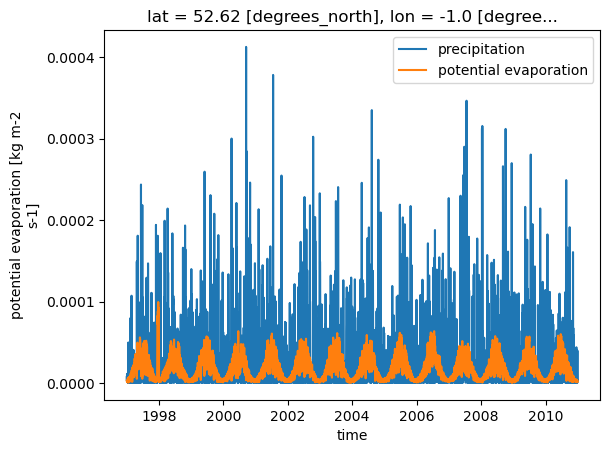

In [7]:
# Quick plot of the precipitation and potential evaporation data
ds_ERA5 = xr.open_mfdataset([ERA5_forcing_object['pr'],ERA5_forcing_object['evspsblpot']])
ds_ERA5["pr"].plot(label = 'precipitation')
ds_ERA5["evspsblpot"].plot(label = 'potential evaporation')
plt.legend()

## CMIP historical forcing

In [8]:
print(settings['CMIP_info'])

{
    'dataset': ['MPI-ESM1-2-HR'],
    'ensembles': ['r1i1p1f1'],
    'experiments': ['historical', 'ssp126', 'ssp245', 'ssp370', 'ssp585'],
    'project': 'CMIP6',
    'frequency': 'day',
    'grid': 'gn',
    'variables': ['pr', 'tas', 'rsds']
}

In [9]:
cmip_dataset = {
    "dataset": settings['CMIP_info']['dataset'],
    "project": settings['CMIP_info']['project'],
    "grid": "gn",
    "exp": "historical",
    "ensemble": settings['CMIP_info']['ensembles'],
}

In [10]:
# Create a subfolder for this specific combination of dataset, experiment and ensemblemember
for dataset in cmip_dataset["dataset"]:
    for ensemble in cmip_dataset["ensemble"]:

        path_CMIP6 = Path(settings['path_CMIP6']) / dataset / cmip_dataset["exp"] / ensemble
        path_CMIP6.mkdir(exist_ok=True, parents=True)

        cmip_dataset2 = {
            "dataset": dataset,
            "project": settings['CMIP_info']['project'],
            "grid": "gn",
            "exp": "historical",
            "ensemble": ensemble,
        }
        # Generate forcing:        
        CMIP_forcing_object = ewatercycle.forcing.sources["LumpedMakkinkForcing"].generate(
           dataset=cmip_dataset2,
           start_time=settings['calibration_start_date'],
           end_time=settings['validation_end_date'],
           directory=path_CMIP6,
           shape=settings['path_shape'],
        )

In [11]:
# Print final CMIP forcing object
print(CMIP_forcing_object)

LumpedMakkinkForcing(
    start_time='1997-08-01T00:00:00Z',
    end_time='2010-07-31T00:00:00Z',
    directory=PosixPath('/home/mmelotto/ewatercycleClimateImpact/HBV/data/camelsgb_28093/CMIP6/MPI-ESM1-2-HR/histor
ical/r1i1p1f1/work/diagnostic/script'),
    shape=PosixPath('/home/mmelotto/ewatercycleClimateImpact/HBV/data/camelsgb_28093/caravan/camelsgb_28093.shp'),
    filenames={
        'pr': 'CMIP6_MPI-ESM1-2-HR_day_historical_r1i1p1f1_pr_gn_1997-2010.nc',
        'tas': 'CMIP6_MPI-ESM1-2-HR_day_historical_r1i1p1f1_tas_gn_1997-2010.nc',
        'rsds': 'CMIP6_MPI-ESM1-2-HR_day_historical_r1i1p1f1_rsds_gn_1997-2010.nc',
        'evspsblpot': 'Derived_Makkink_evspsblpot.nc'
    }
)

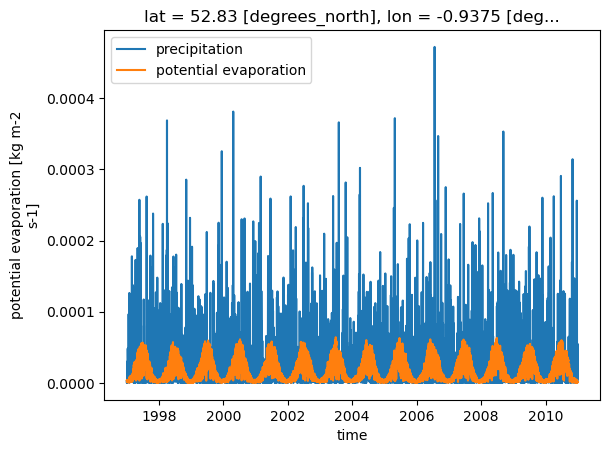

In [12]:
# Quick plot of the precipitation and potential evaporation data
ds_CMIP = xr.open_mfdataset([CMIP_forcing_object['pr'],CMIP_forcing_object['evspsblpot']])
ds_CMIP["pr"].plot(label = 'precipitation')
ds_CMIP["evspsblpot"].plot(label = 'potential evaporation')
plt.legend()